<a href="https://colab.research.google.com/github/abh2180/te-binding-ml4fg/blob/main/notebooks/02_qc_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os

# Project root & paths (same layout as 01_preprocessing)
PROJECT_ROOT = "/content/drive/MyDrive/te-binding-ml4fg-data"
PROC_DIR = PROJECT_ROOT + "/processed"
INTERSECT_DIR = PROC_DIR + "/intersections"

print("PROC_DIR:", PROC_DIR)
print("INTERSECT_DIR:", INTERSECT_DIR)

# RBPs you processed in 01_preprocessing
RBPS = [
    "HNRNPC",
    "HNRNPA1",
    "IGF2BP1",
    "TARDBP",
    "ELAVL1",
    "FMR1",
    "LIN28B",
    "PTBP1",
    "YBX3",
]
print("RBPs:", RBPS)


Mounted at /content/drive
PROC_DIR: /content/drive/MyDrive/te-binding-ml4fg-data/processed
INTERSECT_DIR: /content/drive/MyDrive/te-binding-ml4fg-data/processed/intersections
RBPs: ['HNRNPC', 'HNRNPA1', 'IGF2BP1', 'TARDBP', 'ELAVL1', 'FMR1', 'LIN28B', 'PTBP1', 'YBX3']


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120  # nicer resolution

def load_te_summary(rbp, intersect_dir=INTERSECT_DIR):
    """
    Load the per-RBP TE summary CSV created in 01_preprocessing.
    Expected columns: te_class_id, te_family_id, te_gene_id, te_name
    """
    path = os.path.join(intersect_dir, f"{rbp}_TE_summary.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing summary for {rbp}: {path}")
    df = pd.read_csv(path)
    return df


In [3]:
class_counts = {}
family_counts = {}

for rbp in RBPS:
    df = load_te_summary(rbp)

    # Drop NA just in case
    class_counts[rbp] = df["te_class_id"].dropna().value_counts()
    family_counts[rbp] = df["te_family_id"].dropna().value_counts()

# Combine into matrices: rows = RBPs, columns = classes/families
class_df = pd.DataFrame(class_counts).T.fillna(0).astype(int)
family_df_total = pd.DataFrame(family_counts).T.fillna(0).astype(int)

print("TE classes table (rows=RBP, cols=class):")
display(class_df.head())

print("\nTE families table (rows=RBP, cols=family):")
display(family_df_total.iloc[:, :10])


TE classes table (rows=RBP, cols=class):


te_class_id,DNA,DNA?,LINE,LTR,LTR?,RC,RC?,RNA,Retroposon,SINE,Satellite,Unknown
HNRNPC,34,0,103,17,0,1,0,0,0,2688,2,0
HNRNPA1,13598,37,49666,20181,160,38,8,99,134,29525,167,64
IGF2BP1,1080,14,3259,1091,13,1,3,7,9,2243,13,13
TARDBP,724,1,4243,968,6,3,1,15,10,5929,70,1
ELAVL1,15530,48,114363,12225,166,47,15,50,176,93129,75,101



TE families table (rows=RBP, cols=family):


te_family_id,5S-Deu-L2,Alu,CR1,DNA,Dong-R4,ERV1,ERVK,ERVL,ERVL-MaLR,Gypsy
HNRNPC,0,2674,3,0,0,8,0,3,6,0
HNRNPA1,59,12016,2231,68,9,5347,359,5575,8613,231
IGF2BP1,8,1468,144,18,3,341,30,265,436,19
TARDBP,5,5344,86,4,0,258,11,283,393,18
ELAVL1,37,83018,2049,78,22,4194,280,2231,5251,212
FMR1,2,1365,44,1,0,120,10,66,128,8
LIN28B,13,8662,343,27,2,789,73,752,1575,44
PTBP1,2,3856,236,2,0,615,28,375,971,33
YBX3,18,4103,247,14,0,735,76,613,1343,41


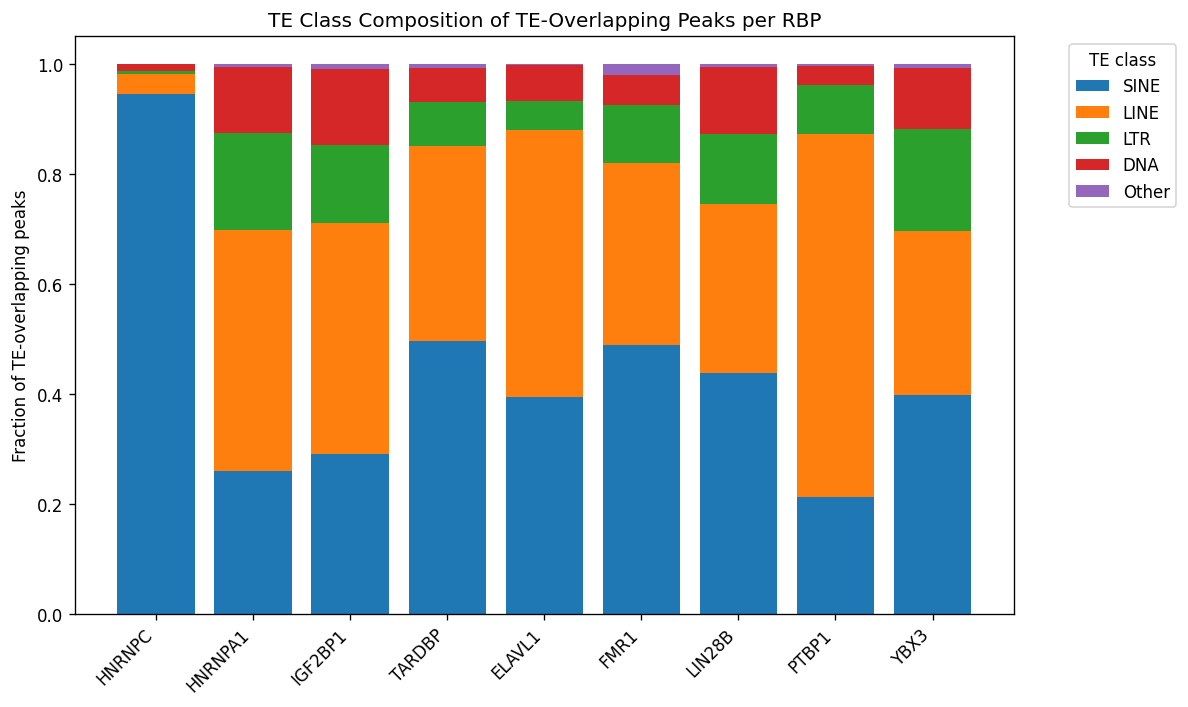

In [4]:
# Restrict to the main TE classes and bucket the rest as "Other"
main_classes = ["SINE", "LINE", "LTR", "DNA"]
all_classes = list(class_df.columns)

other_classes = [c for c in all_classes if c not in main_classes]

class_df_reduced = class_df.copy()
if other_classes:
    class_df_reduced["Other"] = class_df_reduced[other_classes].sum(axis=1)
    class_df_reduced = class_df_reduced[main_classes + ["Other"]]
else:
    class_df_reduced = class_df_reduced[main_classes]

# Convert to fractions per RBP so bars are comparable
class_frac_df = class_df_reduced.div(class_df_reduced.sum(axis=1), axis=0)

# Plot stacked bar: one bar per RBP, segments = TE class fractions
plt.figure(figsize=(10, 6))

bottom = np.zeros(len(RBPS))
x = np.arange(len(RBPS))

for te_class in class_frac_df.columns:
    values = class_frac_df[te_class].values
    plt.bar(x, values, bottom=bottom, label=te_class)
    bottom += values

plt.xticks(x, RBPS, rotation=45, ha="right")
plt.ylabel("Fraction of TE-overlapping peaks")
plt.title("TE Class Composition of TE-Overlapping Peaks per RBP")
plt.legend(title="TE class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Top 15 TE families across all RBPs:


,count
te_family_id,
L1,138985
Alu,122506
L2,53216
MIR,34255
ERVL-MaLR,18716
hAT-Charlie,18462
TcMar-Tigger,13588
ERV1,12407
ERVL,10163


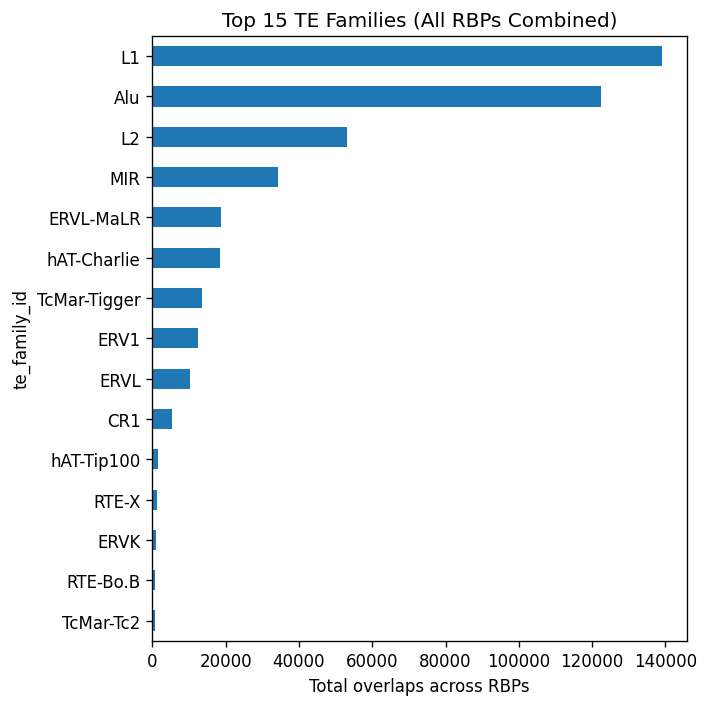

In [5]:
# Aggregate family counts across all RBPs
total_family_counts = family_df_total.sum(axis=0).sort_values(ascending=False)

top_n = 15
top_families = total_family_counts.head(top_n)
print(f"Top {top_n} TE families across all RBPs:")
display(top_families.to_frame("count"))

plt.figure(figsize=(6, 6))
top_families.sort_values().plot(kind="barh")
plt.xlabel("Total overlaps across RBPs")
plt.title(f"Top {top_n} TE Families (All RBPs Combined)")
plt.tight_layout()
plt.show()


In [6]:
rows = []

for rbp in RBPS:
    counts = family_counts[rbp]
    top_fams = counts.sort_values(ascending=False).head(5)
    for fam, ct in top_fams.items():
        rows.append({"rbp": rbp, "family": fam, "count": ct})

top_fam_df = pd.DataFrame(rows)
display(top_fam_df)

# Optionally pivot to a matrix (NaNs where missing)
pivot = top_fam_df.pivot(index="rbp", columns="family", values="count").fillna(0).astype(int)
print("\nRBP × TE family (only top 5 per RBP filled):")
display(pivot)


,rbp,family,count
0,HNRNPC,Alu,2674
1,HNRNPC,L1,86
2,HNRNPC,hAT-Charlie,20
3,HNRNPC,MIR,14
4,HNRNPC,L2,14
5,HNRNPA1,L2,24379
6,HNRNPA1,L1,22165
7,HNRNPA1,MIR,17450
8,HNRNPA1,Alu,12016
9,HNRNPA1,ERVL-MaLR,8613



RBP × TE family (only top 5 per RBP filled):


family,Alu,ERVL-MaLR,L1,L2,MIR,hAT-Charlie
rbp,,,,,,
ELAVL1,83018,0,96260,15176,10074,7816
FMR1,1365,128,633,329,158,0
HNRNPA1,12016,8613,22165,24379,17450,0
HNRNPC,2674,0,86,14,14,20
IGF2BP1,1468,0,1905,1122,767,514
LIN28B,8662,0,4834,2443,2381,1617
PTBP1,3856,971,8048,6616,943,0
TARDBP,5344,393,2767,1364,580,0
YBX3,4103,1343,2287,1773,1888,0
